In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import timeit
from astropy.cosmology import Planck18 as cosmo

def get_xyz(filename):
    f = fits.open(filename)
    data = f[1].data
    header = f[1].header
    ra,dec,redshift = data["RA"],data["DEC"],data["Z"]

    d = cosmo.comoving_distance(redshift)

#     plt.plot(ra,dec,".",markersize=1)
#     plt.xlabel(r"RA [$\degree$]")
#     plt.ylabel(r"DEC [$\degree$]")
#     plt.show()

    d = d.value
    idx = (d>0)
    ra,dec,d = ra[idx],dec[idx],d[idx]

#     plt.plot(ra,dec,".",markersize=1)
#     plt.xlabel(r"RA [$\degree$]")
#     plt.ylabel(r"DEC [$\degree$]")
#     plt.show()

    conv = np.pi / 180
    x = d*np.cos(conv*ra)*np.cos(conv*dec)
    y = d*np.sin(conv*ra)*np.cos(conv*dec)
    z = d*np.sin(conv*dec)
    print(len(x))

    return (x,y,z)

x,y,z = get_xyz("ELG_N_clustering.dat.fits")
# once the sample is selected, will have 3 arrays: x,y,z

# choosing bins:
# bins = 10 ** np.linspace(np.log10(1.0/10), np.log10(20), 20)
bins = np.linspace(1.0/10, 20, 30) # Mpc
bin_centers = 0.5 * (bins[1:] + bins[:-1])

t_start = timeit.default_timer() # starting timer

# calculating separation between all objects:
n = len(x) # number of objects

# DD:
sep = np.zeros(int(n*(n-1)/2)) - 1
previous = 0
for i in range(n):
    dist = np.sqrt( (x[i]-x[i+1:n])**2 + (y[i]-y[i+1:n])**2 + (z[i]-z[i+1:n])**2)
    dist = dist[dist<20]
    sep[previous:previous+len(dist)] = dist.copy()
    previous += len(dist)
print("Done with DD seps")

sep= sep[sep != -1]
dd = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    left = bins[i]
    right = bins[i+1]
    dd[i] = np.sum((sep>left) & (sep<right))

DD = dd / (n*(n-1)/2) # normalize DD

# averaging dr and rr over multiple random datasets (by adding and then dividing after loop), via Zheng's advice:

DR,RR = np.zeros_like(DD), np.zeros_like(DD)
num_rsamples = 5
for num in range(5,10):
    randx,randy,randz = get_xyz("ELG_N_" + str(num) + "_clustering.ran.fits")
    randn = len(randx)

    # DR:
    sep = np.zeros(int(n*randn)) - 1
    previous = 0
    for i in range(n):
        dist = np.sqrt( (x[i]-randx)**2 + (y[i]-randy)**2 + (z[i]-randz)**2)
        dist = dist[dist<20]
        sep[previous:previous+len(dist)] = dist.copy()
        previous += len(dist)
    print("Done with DR seps")

    sep= sep[sep != -1]
    dr = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        left = bins[i]
        right = bins[i+1]
        dr[i] = np.sum((sep>left) & (sep<right))
        
    DR += (dr / randn / n) # normalize DR


    # RR:
    sep = np.zeros(int(randn*(randn-1)/2)) - 1
    previous = 0
    for i in range(randn):
        dist = np.sqrt( (randx[i]-randx[i+1:randn])**2 + (randy[i]-randy[i+1:randn])**2 + (randz[i]-randz[i+1:randn])**2)
        dist = dist[dist<20]
        sep[previous:previous+len(dist)] = dist.copy()
        previous += len(dist)
    print("Done with RR seps")

    sep= sep[sep != -1]
    rr = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        left = bins[i]
        right = bins[i+1]
        rr[i] = np.sum((sep>left) & (sep<right))
        
    RR += (rr / (randn*(randn-1)/2)) # normalize RR

DR = DR / num_rsamples
RR = RR / num_rsamples

t_stop = timeit.default_timer() # stopping the timer
print("Seconds to calculate separations: ", t_stop-t_start)

# calculate Landy-Szalay estimator for 2pcf:
xi = (DD - 2*DR + RR) / RR
print(xi)

14010
Done with DD seps
21835
Done with DR seps
Done with RR seps
21794
Done with DR seps
Done with RR seps
21767
Done with DR seps
Done with RR seps
21884
Done with DR seps
Done with RR seps
21753
Done with DR seps
Done with RR seps
Seconds to calculate separations:  63.1807693
[40.9513404  11.9675      6.42233914  4.40022301  3.05627666  2.22349976
  1.8654921   1.38683989  1.30400607  0.99906168  1.00884825  0.86977182
  0.74819036  0.74964088  0.65495505  0.55324682  0.50943436  0.55128108
  0.44843438  0.33083983  0.33047335  0.31250288  0.32190881  0.34575254
  0.28457556  0.29770717  0.26243294  0.26979044  0.23334568]


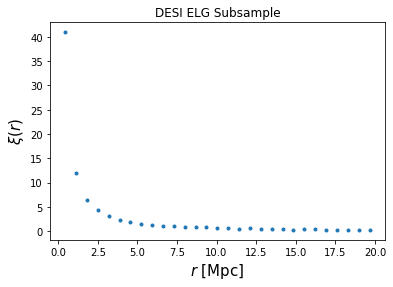

In [3]:
# plot results:
# plt.plot(bin_centers, bin_centers**2*xi, ".")
plt.plot(bin_centers, xi, ".")
# plt.xscale("log") # log scale
# plt.yscale("log")
# plt.ylim(0,1)
plt.xlabel(r"$r$ [Mpc]", fontsize=15)
plt.ylabel(r"$\xi(r)$", fontsize=15)
plt.title("DESI ELG Subsample")
plt.show()

To save a text file

In [11]:
with open("corrs_ELG.txt", "w") as f:
    f.write("#number of galaxies: "+str(len(x))+"\n")
    for a in bin_centers:
        f.write(str(a)+" ")
    f.write("\n")
    for a in xi:
        f.write(str(a)+" ")
f.close

<function TextIOWrapper.close()>